https://playinpap.github.io/ltv-practice/

In [1]:
import pandas as pd
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials


warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format


df = pd.read_csv("병합데이터.csv")
df = df.drop(['Unnamed: 0'], axis = 1)
df.head(1)


,거래일자,수수료율,고객ID,프로그램수정횟수,추가결제금액,거래취소여부,거래취소일자,서비스명,판매자,판매금액,서비스가격,평점,이용자수,대분류,서비스번호,사용기기,사용OS,유입경로,회원상태,거주지,연령,성별,서비스총구매수,총구매금액,총수정요청수,총추가결제금액,판매자ID,판매 서비스 수,총 판매 금액,프리미엄 서비스 가입여부,신속 알람 서비스 사용여부,판매수
0,20210201,6.50000,5030100140,0.00000,9800,0.00000,0.00000,"카페24,고도몰,메이크샵등 쇼핑몰 수정,코딩,유지보수",logf1,14800.00000,5000.00000,5.00000,584.00000,커머스,2102.00000,iPhone,iOS11.4.1,유튜브,정상회원,경상도,20.0,남성,8,250400.00000,0.00000,72400,V2_1008,402,4497380,미가입,미사용,402


In [3]:
df['거래일자'] = pd.to_datetime(df['거래일자'], format='%Y%m%d')

# 판매자: NULL인 것 제외
df = df[pd.notnull(df['판매자'])] 

# 고객 번호, 주문 일자, 구매 금액만 남기고 지우기
cols_of_interest = ['판매자', '거래일자', '판매금액']
df = df[cols_of_interest]

df

,판매자,거래일자,판매금액
0,logf1,2021-02-01,14800.00000
1,logf1,2021-02-01,5000.00000
2,엑셀의신,2021-02-01,19200.00000
3,태구리,2021-02-01,61000.00000
4,태구리,2021-02-01,50000.00000
...,...,...,...
344272,전문가오리,2021-06-30,20000.00000
344273,전문가오리,2021-06-30,20000.00000
344274,전문가오리,2021-06-30,20000.00000
344275,전문가오리,2021-06-30,20000.00000


- frequency	F	고객별 구매 일수
- recency	R	고객별 첫 구매 ~ 마지막 구매까지의 시간
- T	T	고객별 첫 구매 ~ 집계일까지의 시간
- monetary_value	M	고객별 평균 구매 금액

- 총 3번 판매했고 (frequency),
- 마지막 구매일 - 첫 구매일은 60일 (recency),
- 집계일 - 첫 구매일은 134일 (T)이며,
- 평균 구매 금액은 32267원 정도 (monetary_value)임을 의미

In [4]:
current_date = df['거래일자'].max()

metrics_df = summary_data_from_transaction_data(df
                                          , customer_id_col = '판매자'
                                          , datetime_col = '거래일자'
                                          , monetary_value_col='판매금액'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
판매자,,,,
0to1,3.00000,60.00000,134.00000,32266.66667
100ME,65.00000,172.00000,174.00000,595729.23077
10xDeveloper,30.00000,175.00000,177.00000,148390.66667
10년차웹개발자,44.00000,174.00000,177.00000,90317.27273
123abc,0.00000,0.00000,36.00000,0.00000


# Z 스코어 생성

In [5]:
metrics_df = metrics_df[(metrics_df['monetary_value'] > 0) & (metrics_df['frequency'] > 0)]

metrics_df['Z'] = (metrics_df['T'] - metrics_df['recency']) * metrics_df['frequency'] / metrics_df['recency']

metrics_df

,frequency,recency,T,monetary_value,Z
판매자,,,,,
0to1,3.00000,60.00000,134.00000,32266.66667,3.70000
100ME,65.00000,172.00000,174.00000,595729.23077,0.75581
10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286
10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862
12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000
...,...,...,...,...,...
회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207
효베르,155.00000,179.00000,179.00000,147655.67742,0.00000
흐,1.00000,82.00000,155.00000,113600.00000,0.89024


# 시그모이드 씌우기

In [6]:
metrics_df['Z_sigmoid'] = 1 / (1 + np.exp( - (metrics_df['Z'] - metrics_df['Z'].mean() )))
metrics_df

,frequency,recency,T,monetary_value,Z,Z_sigmoid
판매자,,,,,,
0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545
100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296
10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305
10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349
12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720
...,...,...,...,...,...,...
회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594
효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720
흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920


# D값 생성하기

In [7]:
metrics_df['D'] =  metrics_df['T'] - metrics_df['recency']

metrics_df

,frequency,recency,T,monetary_value,Z,Z_sigmoid,D
판매자,,,,,,,
0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000
100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000
10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000
10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000
12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000
...,...,...,...,...,...,...,...
회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594,21.00000
효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720,0.00000
흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920,73.00000


# =======================================================

In [8]:
example = df[df['판매자']=='0to1']
example.head()

print(len(example['거래일자'].unique())-1)

# recency = 365: 최대 주문일 - 최소 주문일
print(max(example['거래일자']) - min(example['거래일자']))

# T = 367: 집계일 - 최소 주문일
print(current_date - min(example['거래일자']))

# monetary_value = 599.701667, 평균 구매 금액
ex_daily_sales = example.groupby("거래일자")["판매금액"].sum()
print(np.mean(ex_daily_sales[1:]))

3
60 days 00:00:00
134 days 00:00:00
32266.666666666668


In [9]:
holdout_days = 30
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                          ,customer_id_col = '판매자'
                                          ,datetime_col = '거래일자'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='판매금액')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
판매자,,,,,,,
0to1,3.00000,60.00000,104.00000,32266.66667,0.00000,0.00000,30.00000
100ME,52.00000,144.00000,144.00000,589051.53846,13.00000,79330.58824,30.00000
10xDeveloper,27.00000,147.00000,147.00000,147505.18519,3.00000,18763.20000,30.00000
10년차웹개발자,33.00000,145.00000,147.00000,91303.03030,11.00000,19611.42857,30.00000
123abc,0.00000,0.00000,6.00000,0.00000,0.00000,0.00000,30.00000


In [10]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

In [11]:
# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs[inputs['monetary_value_cal'] > 0]  # 0 이하의 값 필터링
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [12]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials            
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

100%|██████████| 100/100 [00:06<00:00, 14.47trial/s, best loss: 4.289808240493475]
0.9992259031770566


In [13]:
trials = Trials()

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|██████████| 100/100 [00:03<00:00, 28.89trial/s, best loss: 35757521.77768009]
0.00011129925545422248


In [14]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd) #l2_bgnbd = hyperopt로 나온 결과
# calibration 데이터의 R,F,T로 모형 적합
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal']) 

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))

MSE: 4.289808240493475


In [15]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.41304,0.01003,0.39338,0.43270
alpha,2.41471,0.11165,2.19587,2.63354
a,0.00039,0.00027,-0.00013,0.00092
b,0.03022,0.01423,0.00234,0.05811


- 여기서 T 기간동안의 평균 판매 횟수가 λT 이므로 λ에 대한 분포는 1일 단위

- 0.5 쯤부터 확률이 0으로 수렴하고 있는데 대부분 고객들이 1일의 평균 구매 횟수는 최대 0.2 정도임을 의미

- 즉, 최대 5일에 한 번 꼴로 판매로 해석 가능



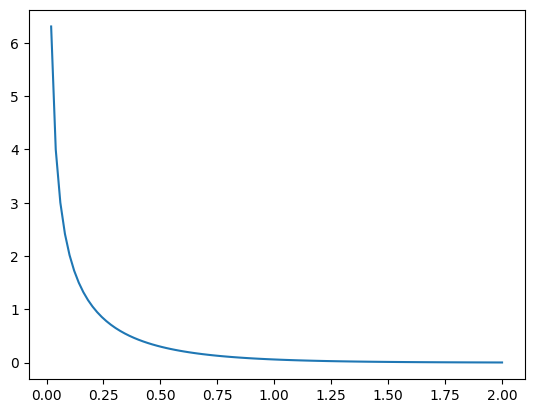

In [16]:
# 고객별 lambda (구매율) 의 분포
from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

In [17]:
filtered_df

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
판매자,,,,,,,
0to1,3.00000,60.00000,104.00000,32266.66667,0.00000,0.00000,30.00000
100ME,52.00000,144.00000,144.00000,589051.53846,13.00000,79330.58824,30.00000
10xDeveloper,27.00000,147.00000,147.00000,147505.18519,3.00000,18763.20000,30.00000
10년차웹개발자,33.00000,145.00000,147.00000,91303.03030,11.00000,19611.42857,30.00000
12년차기획전문가,124.00000,149.00000,149.00000,402091.93548,25.00000,47822.70531,30.00000
...,...,...,...,...,...,...,...
황코딩,1.00000,28.00000,133.00000,1236000.00000,1.00000,562200.00000,30.00000
효베르,128.00000,149.00000,149.00000,142574.14062,27.00000,14491.06250,30.00000
흐,1.00000,82.00000,125.00000,113600.00000,0.00000,0.00000,30.00000


In [18]:
filtered_df = filtered_df[filtered_df['monetary_value_cal'] > 0]

spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 35757521.77768009


In [19]:
final_df = whole_filtered_df.copy()
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time=6,
                                                     discount_rate = 0
                                                     )

In [20]:
t=180 #365일
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

In [21]:
final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])

In [22]:
final_df.sort_values(by="ltv", ascending = False)

,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value
판매자,,,,,,,,,,
elsoft,1.00000,1.00000,3.00000,18063000.00000,2.00000,0.54024,2.00000,852068706.27758,45.76909,18616684.06688
디프라이,3.00000,32.00000,58.00000,24680433.33333,2.43750,0.64538,26.00000,253044377.49843,10.15119,24927556.04139
Sailorkr,5.00000,46.00000,85.00000,18000600.00000,4.23913,0.91686,39.00000,201299684.72921,11.11642,18108313.04307
기획자심근수,5.00000,71.00000,84.00000,15615400.00000,0.91549,0.28430,13.00000,177024860.74189,11.26912,15708841.08081
김러그,16.00000,162.00000,168.00000,8540885.00000,0.59259,0.22337,6.00000,148310522.93397,17.33249,8556791.55602
...,...,...,...,...,...,...,...,...,...,...
Chance235,1.00000,12.00000,162.00000,10000.00000,12.50000,0.99998,150.00000,11388.84317,1.10197,10335.00553
정의현123,1.00000,125.00000,139.00000,5000.00000,0.11200,0.15101,14.00000,9178.87110,1.77138,5181.74871
별토깽,16.00000,71.00000,178.00000,34656.25000,24.11268,1.00000,107.00000,8391.14178,0.24166,34722.51783


In [23]:
final_df = final_df.reset_index()
final_df

,판매자,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value
0,0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000,146367.32830,4.48993,32599.04452
1,100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000,39771928.45072,66.73116,596002.34821
2,10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000,4531457.77734,30.50689,148538.83865
3,10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000,4026397.90376,44.55015,90378.98858
4,12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000,59459800.73057,148.22508,401145.35320
...,...,...,...,...,...,...,...,...,...,...,...
1643,회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594,21.00000,18935953.42118,3.06212,6183936.67159
1644,효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720,0.00000,22769563.81768,154.17739,147684.19189
1645,흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920,73.00000,183435.52832,1.56635,117110.48676
1646,희몽,4.00000,93.00000,150.00000,10000.00000,2.45161,0.64860,57.00000,52479.28187,5.20531,10081.86933


# 할인율 추가

In [24]:
final_df['이탈위험도'] = (final_df['frequency'] * final_df['monetary_value']) / final_df['ltv']
final_df

,판매자,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value,이탈위험도
0,0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000,146367.32830,4.48993,32599.04452,0.66135
1,100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000,39771928.45072,66.73116,596002.34821,0.97361
2,10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000,4531457.77734,30.50689,148538.83865,0.98240
3,10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000,4026397.90376,44.55015,90378.98858,0.98698
4,12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000,59459800.73057,148.22508,401145.35320,1.00503
...,...,...,...,...,...,...,...,...,...,...,...,...
1643,회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594,21.00000,18935953.42118,3.06212,6183936.67159,0.31686
1644,효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720,0.00000,22769563.81768,154.17739,147684.19189,1.00514
1645,흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920,73.00000,183435.52832,1.56635,117110.48676,0.61929
1646,희몽,4.00000,93.00000,150.00000,10000.00000,2.45161,0.64860,57.00000,52479.28187,5.20531,10081.86933,0.76221


In [25]:
final_df['pre_ltv'] = final_df['frequency'] * final_df['monetary_value']
final_df

,판매자,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value,이탈위험도,pre_ltv
0,0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000,146367.32830,4.48993,32599.04452,0.66135,96800.00000
1,100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000,39771928.45072,66.73116,596002.34821,0.97361,38722400.00000
2,10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000,4531457.77734,30.50689,148538.83865,0.98240,4451720.00000
3,10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000,4026397.90376,44.55015,90378.98858,0.98698,3973960.00000
4,12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000,59459800.73057,148.22508,401145.35320,1.00503,59758700.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594,21.00000,18935953.42118,3.06212,6183936.67159,0.31686,6000000.00000
1644,효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720,0.00000,22769563.81768,154.17739,147684.19189,1.00514,22886630.00000
1645,흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920,73.00000,183435.52832,1.56635,117110.48676,0.61929,113600.00000
1646,희몽,4.00000,93.00000,150.00000,10000.00000,2.45161,0.64860,57.00000,52479.28187,5.20531,10081.86933,0.76221,40000.00000


# 이탈클래스 생성

In [26]:
def func1(x):
    if x >= 0.9:
        return '이탈'
    elif  x >= 0.5:
        return '이탈위험군'
    else:
        return '비위험군'

final_df['이탈클래스'] = final_df['Z_sigmoid'].apply(func1)

final_df.head()

,판매자,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value,이탈위험도,pre_ltv,이탈클래스
0,0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000,146367.32830,4.48993,32599.04452,0.66135,96800.00000,이탈위험군
1,100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000,39771928.45072,66.73116,596002.34821,0.97361,38722400.00000,비위험군
2,10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000,4531457.77734,30.50689,148538.83865,0.98240,4451720.00000,비위험군
3,10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000,4026397.90376,44.55015,90378.98858,0.98698,3973960.00000,비위험군
4,12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000,59459800.73057,148.22508,401145.35320,1.00503,59758700.00000,비위험군


In [30]:
pd.DataFrame(final_df.groupby('이탈클래스')['ltv'].mean())

,ltv
이탈클래스,
비위험군,13391720.92733
이탈,7467923.40116
이탈위험군,15525149.15157


In [ ]:
final_df['한달평균_ltv'] = final_df['ltv'] / 6


final_df['현행수수료'] = final_df['한달평균_ltv'] * 0.07 * 6

# 개선 수수료 적용

In [33]:
def calculate_tiered_refund(sale_amount):
    refund_amount = 0
    # 구간별로 판매 금액 분할 및 환급율 적용
    if sale_amount > 10000000:  # 1000만 원 이상
        refund_amount += (sale_amount - 10000000) * 0.03
        sale_amount = 10000000  # 다음 구간으로 한정4
    if sale_amount > 5000000:   # 500만 원 이상
        refund_amount += (sale_amount - 5000000) * 0.05  # 50% 환급 수수료5%
        sale_amount = 5000000  # 다음 구간으로 한정
    if sale_amount > 2000000:   # 200만 원 이상
        refund_amount += (sale_amount - 2000000) * 0.07  # 30% 환급 수수료7%
        sale_amount = 2000000  # 다음 구간으로 한정
    if sale_amount > 1000000:   # 100만 원 이상
        refund_amount += (sale_amount - 1000000) * 0.09  # 10% 환급 수수료9%
        sale_amount = 1000000
    if sale_amount <= 1000000:
        refund_amount += (sale_amount) * 0.1
    return refund_amount

final_df['개선수수료'] = final_df['한달평균_ltv'].apply(calculate_tiered_refund) * 6
final_df

,판매자,frequency,recency,T,monetary_value,Z,Z_sigmoid,D,ltv,predicted_purchases,predicted_monetary_value,이탈위험도,pre_ltv,이탈클래스,한달평균_ltv,현행수수료,개선수수료
0,0to1,3.00000,60.00000,134.00000,32266.66667,3.70000,0.86545,74.00000,146367.32830,4.48993,32599.04452,0.66135,96800.00000,이탈위험군,24394.55472,10245.71298,14636.73283
1,100ME,65.00000,172.00000,174.00000,595729.23077,0.75581,0.25296,2.00000,39771928.45072,66.73116,596002.34821,0.97361,38722400.00000,비위험군,6628654.74179,2784034.99155,2888596.42254
2,10xDeveloper,30.00000,175.00000,177.00000,148390.66667,0.34286,0.18305,2.00000,4531457.77734,30.50689,148538.83865,0.98240,4451720.00000,비위험군,755242.96289,317202.04441,453145.77773
3,10년차웹개발자,44.00000,174.00000,177.00000,90317.27273,0.75862,0.25349,3.00000,4026397.90376,44.55015,90378.98858,0.98698,3973960.00000,비위험군,671066.31729,281847.85326,402639.79038
4,12년차기획전문가,149.00000,179.00000,179.00000,401065.10067,0.00000,0.13720,0.00000,59459800.73057,148.22508,401145.35320,1.00503,59758700.00000,비위험군,9909966.78843,4162186.05114,3872990.03653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,회사도움꾼,1.00000,58.00000,79.00000,6000000.00000,0.36207,0.18594,21.00000,18935953.42118,3.06212,6183936.67159,0.31686,6000000.00000,비위험군,3155992.23686,1325516.73948,1625516.73948
1644,효베르,155.00000,179.00000,179.00000,147655.67742,0.00000,0.13720,0.00000,22769563.81768,154.17739,147684.19189,1.00514,22886630.00000,비위험군,3794927.30295,1593869.46724,1893869.46724
1645,흐,1.00000,82.00000,155.00000,113600.00000,0.89024,0.27920,73.00000,183435.52832,1.56635,117110.48676,0.61929,113600.00000,비위험군,30572.58805,12840.48698,18343.55283
1646,희몽,4.00000,93.00000,150.00000,10000.00000,2.45161,0.64860,57.00000,52479.28187,5.20531,10081.86933,0.76221,40000.00000,이탈위험군,8746.54698,3673.54973,5247.92819


In [34]:
final_df['개선수수료'].sum() / final_df['현행수수료'].sum()

1.098687228171911

# 현행/개선 수수료 차이 확인

In [35]:
print(final_df['개선수수료'].sum())
print(final_df['현행수수료'].sum())

1662787947.8720217
1513431580.194765


- 이탈위험군인 애들을 기준으로 현행, 개선 수수료정책을 적용해본 결과
- 실제로 이탈위험군에 수수료가 약 13%가량 감소한 것을 보인다
- 이는 이탈위험군의 유인정책이 될 수 있다

In [276]:
print(final_df[final_df['이탈클래스'] == '이탈위험군']['현행수수료'].sum())
print('=' * 50)
print(final_df[final_df['이탈클래스'] == '이탈위험군']['개선수수료'].sum())
print('=' * 50)
print(1 - (final_df[final_df['이탈클래스'] == '이탈위험군']['개선수수료'].sum() / final_df[final_df['이탈클래스'] == '이탈위험군']['현행수수료'].sum()) )

200260766.80787414
174469417.5873705
0.12878882684618542
